# Problem Understanding

#### What is the Airbnb business model?

- Marketplace: connect people offering homestays with people looking for homestays.
                  
- Gross Revenue = (Fee * Users) - CAC

# Libraries

In [67]:
import pandas as pd
import numpy as np
import seaborn as sns
import random

from IPython.display import Image
from matplotlib import pyplot as plt
from keras import models as ml
from keras import layers as l
from scikitplot import metrics as mt

from sklearn import model_selection as ms
from sklearn import preprocessing as pp
from sklearn import metrics as m

## Helper Functions

## Loading Data

In [2]:
data_raw_age_gender = pd.read_csv("datasets/age_gender_bkts.csv", low_memory=False)
data_raw_age_gender

,age_bucket,country_destination,gender,population_in_thousands,year
0,100+,AU,male,1.0,2015.0
1,95-99,AU,male,9.0,2015.0
2,90-94,AU,male,47.0,2015.0
3,85-89,AU,male,118.0,2015.0
4,80-84,AU,male,199.0,2015.0
...,...,...,...,...,...
415,95-99,US,male,115.0,2015.0
416,90-94,US,male,541.0,2015.0
417,15-19,US,female,10570.0,2015.0
418,85-89,US,male,1441.0,2015.0


In [3]:
data_raw_countries = pd.read_csv("datasets/countries.csv", low_memory=False)
data_raw_countries

,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance
0,AU,-26.853388,133.275160,15297.7440,7741220.0,eng,0.00
1,CA,62.393303,-96.818146,2828.1333,9984670.0,eng,0.00
2,DE,51.165707,10.452764,7879.5680,357022.0,deu,72.61
3,ES,39.896027,-2.487694,7730.7240,505370.0,spa,92.25
4,FR,46.232193,2.209667,7682.9450,643801.0,fra,92.06
5,GB,54.633220,-3.432277,6883.6590,243610.0,eng,0.00
6,IT,41.873990,12.564167,8636.6310,301340.0,ita,89.40
7,NL,52.133057,5.295250,7524.3203,41543.0,nld,63.22
8,PT,39.553444,-7.839319,7355.2534,92090.0,por,95.45
9,US,36.966427,-95.844030,0.0000,9826675.0,eng,0.00


In [4]:
data_raw_sample_submission = pd.read_csv("datasets/sample_submission_NDF.csv", low_memory=False)
data_raw_sample_submission

,id,country
0,5uwns89zht,NDF
1,jtl0dijy2j,NDF
2,xx0ulgorjt,NDF
3,6c6puo6ix0,NDF
4,czqhjk3yfe,NDF
...,...,...
62091,cv0na2lf5a,NDF
62092,zp8xfonng8,NDF
62093,fa6260ziny,NDF
62094,87k0fy4ugm,NDF


In [5]:
data_raw_sessions = pd.read_csv("datasets/sessions.csv", low_memory=True)
data_raw_sessions

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0
...,...,...,...,...,...,...
10567732,9uqfg8txu3,dashboard,view,dashboard,Windows Desktop,556.0
10567733,9uqfg8txu3,edit,view,edit_profile,Windows Desktop,6624.0
10567734,9uqfg8txu3,webcam_upload,-unknown-,-unknown-,Windows Desktop,200125.0
10567735,9uqfg8txu3,active,-unknown-,-unknown-,-unknown-,17624.0


In [6]:
data_raw_test_users = pd.read_csv("datasets/test_users.csv", low_memory=False)
data_raw_test_users

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,5uwns89zht,2014-07-01,20140701000006,NaN,FEMALE,35.0,facebook,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
1,jtl0dijy2j,2014-07-01,20140701000051,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
2,xx0ulgorjt,2014-07-01,20140701000148,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome
3,6c6puo6ix0,2014-07-01,20140701000215,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,IE
4,czqhjk3yfe,2014-07-01,20140701000305,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Safari
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62091,cv0na2lf5a,2014-09-30,20140930235232,NaN,-unknown-,31.0,basic,0,en,direct,direct,untracked,Web,Windows Desktop,IE
62092,zp8xfonng8,2014-09-30,20140930235306,NaN,-unknown-,NaN,basic,23,ko,direct,direct,untracked,Android,Android Phone,-unknown-
62093,fa6260ziny,2014-09-30,20140930235408,NaN,-unknown-,NaN,basic,0,de,direct,direct,linked,Web,Windows Desktop,Firefox
62094,87k0fy4ugm,2014-09-30,20140930235430,NaN,-unknown-,NaN,basic,0,en,sem-brand,google,omg,Web,Mac Desktop,Safari


In [7]:
data_raw_train_users = pd.read_csv("datasets/train_users_2.csv", low_memory=False)
data_raw_train_users

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213446,zxodksqpep,2014-06-30,20140630235636,NaN,MALE,32.0,basic,0,en,sem-brand,google,omg,Web,Mac Desktop,Safari,NDF
213447,mhewnxesx9,2014-06-30,20140630235719,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome,NDF
213448,6o3arsjbb4,2014-06-30,20140630235754,NaN,-unknown-,32.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,NDF
213449,jh95kwisub,2014-06-30,20140630235822,NaN,-unknown-,NaN,basic,25,en,other,other,tracked-other,iOS,iPhone,Mobile Safari,NDF


#### Could we merge sesions with train_users?

Sessions and train_users are our main tables. We are going to use both of them in this project. Yet, we cannot merge these tables now because they have different granularity: 

**(1)** train_user is user-level (informations are: one user per row). 

**(2)** sessions is secs_elapsed-level (informations are related to action, action_type, action_detail, device_type and secs_elapse - and this one is the highest level).

To merge the two tables, we need to encoding the columns from sessions. 

In [8]:
# train user
data_raw_train_users[data_raw_train_users["id"] == "nw9fwlyb5f"]

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
213450,nw9fwlyb5f,2014-06-30,20140630235824,NaN,-unknown-,NaN,basic,25,en,direct,direct,untracked,iOS,iPhone,-unknown-,NDF


In [9]:
# sessions
data_raw_sessions[data_raw_sessions["user_id"] == "nw9fwlyb5f"].head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
5555239,nw9fwlyb5f,show,view,user_profile,iPhone,9310.0
5555240,nw9fwlyb5f,show,view,p3,iPhone,33.0
5555241,nw9fwlyb5f,reviews,data,listing_reviews,iPhone,8.0
5555242,nw9fwlyb5f,campaigns,NaN,NaN,iPhone,41983.0
5555243,nw9fwlyb5f,click,click,book_it,iPhone,58491.0


In [10]:
# sessions
data_raw_sessions[(data_raw_sessions["user_id"] == "nw9fwlyb5f") & (data_raw_sessions["action"] == "reviews")].head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
5555241,nw9fwlyb5f,reviews,data,listing_reviews,iPhone,8.0
5555269,nw9fwlyb5f,reviews,data,listing_reviews,iPhone,11.0


# 1. Data Description

In [11]:
df1 = data_raw_train_users.copy()

### Data fields meaning

- id: user id.

- date_account_created: the date of account creation.

- timestamp_first_active: timestamp of the first activity, note that it can be earlier than date_account_created or - date_first_booking because a user can search before signing up.

- date_first_booking: date of first booking.

- gender.

- age.

- signup_method.

- signup_flow: the page a user came to signup up from.

- language: international language preference.

- affiliate_channel: what kind of paid marketing.

- affiliate_provider: where the marketing is e.g. google, craigslist, other.

- first_affiliate_tracked: whats the first marketing the user interacted with before the signing up.

- signup_app.

- first_device_type.

- first_browser.

- country_destination: this is the target variable you are to predict.

## 1.1. Data Dimensions

In [12]:
print("Number of rows: {}".format(df1.shape[0]))
print("Number of cols: {}".format(df1.shape[1]))

Number of rows: 213451
Number of cols: 16


## 1.2. Data Types

In [13]:
df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

In [14]:
df1.sample(3)

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
193090,t4plxxhfql,2014-05-21,20140521225309,NaN,-unknown-,NaN,basic,25,en,direct,direct,untracked,iOS,iPhone,-unknown-,NDF
88430,k8me6251mp,2013-07-03,20130703204530,2013-07-04,MALE,39.0,basic,0,en,direct,direct,untracked,Web,Windows Desktop,Firefox,US
103524,shf4oyxw30,2013-08-30,20130830040940,2014-08-27,MALE,26.0,facebook,0,en,direct,direct,untracked,Web,Windows Desktop,Chrome,US


## 1.3. NA Check

In [15]:
df1.isna().sum()

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                         87990
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
dtype: int64

## 1.4. Removing NA

As we want to deliver a solution as faster as possible, we will remove all NA values in this cycle. However, we may treat NA values using a different technique as next steps.

In [16]:
df1 = df1.dropna()

In [17]:
df1.shape

(68171, 16)

## 1.5. Change Data Type

In [18]:
# date_account_created
df1["date_account_created"] = pd.to_datetime(df1["date_account_created"])

# timestamp_first_active
df1["timestamp_first_active"] = pd.to_datetime(df1["timestamp_first_active"], format="%Y%m%d%H%M%S")

# date_first_booking
df1["date_first_booking"] = pd.to_datetime(df1["date_first_booking"])

# age
df1["age"] = df1["age"].astype(int)

In [19]:
df1.dtypes

id                                 object
date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
date_first_booking         datetime64[ns]
gender                             object
age                                 int64
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
dtype: object

## 1.6. Check Balanced Data

In [20]:
df1["country_destination"].value_counts()

US       48324
other     7557
FR        3687
IT        2029
GB        1768
ES        1695
CA        1070
DE         849
NL         600
AU         434
PT         158
Name: country_destination, dtype: int64

In [21]:
df1["country_destination"].value_counts(normalize=True)

US       0.708864
other    0.110854
FR       0.054085
IT       0.029763
GB       0.025935
ES       0.024864
CA       0.015696
DE       0.012454
NL       0.008801
AU       0.006366
PT       0.002318
Name: country_destination, dtype: float64

- This is a multi-class (many types for the target variable) and very unbalanced (70% of data only for US, for instance). This is a very complex classification problem. 

- Since NDF (no destination found) was a type of country_destination, it is not in our dataset anymore because it belongs to users which did not make their first booking - and we removed these NA values. 

## 1.7. Descriptive Statistics

In [22]:
num_attributes = df1.select_dtypes(include=["int64", "float64"])
cat_attributes = df1.select_dtypes(exclude=["int64", "float64", "datetime64[ns]"])

In [23]:
num_attributes.columns

Index(['age', 'signup_flow'], dtype='object')

In [24]:
cat_attributes.columns

Index(['id', 'gender', 'signup_method', 'language', 'affiliate_channel',
       'affiliate_provider', 'first_affiliate_tracked', 'signup_app',
       'first_device_type', 'first_browser', 'country_destination'],
      dtype='object')

### 1.7.1. Numerical attributes

In [25]:
# Central tendency metrics
c1 = pd.DataFrame(num_attributes.apply(np.mean)).T
c2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion metrics
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(lambda x: x.min() )).T
d3 = pd.DataFrame(num_attributes.apply(lambda x: x.max() )).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis() )).T

# Concatenate metric
metrics = pd.concat([d2, d3, d4, c1, c2, d1, d5, d6]).T.reset_index()
metrics.columns = ["attributes", "min", "max", "range", "mean", "median", "std", "skewness", "kurtosis"]

In [26]:
metrics

,attributes,min,max,range,mean,median,std,skewness,kurtosis
0,age,2.0,2014.0,2012.0,47.857593,33.0,146.035312,13.250136,175.132153
1,signup_flow,0.0,25.0,25.0,2.436857,0.0,6.533959,2.807117,6.439075


- We have maximum age as 2014. This is probably wrong.
- As median is less than mean, we have a left skew: positive skewness. 
- Since age has a 175 value for kurtosis, we have a very high peak.

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


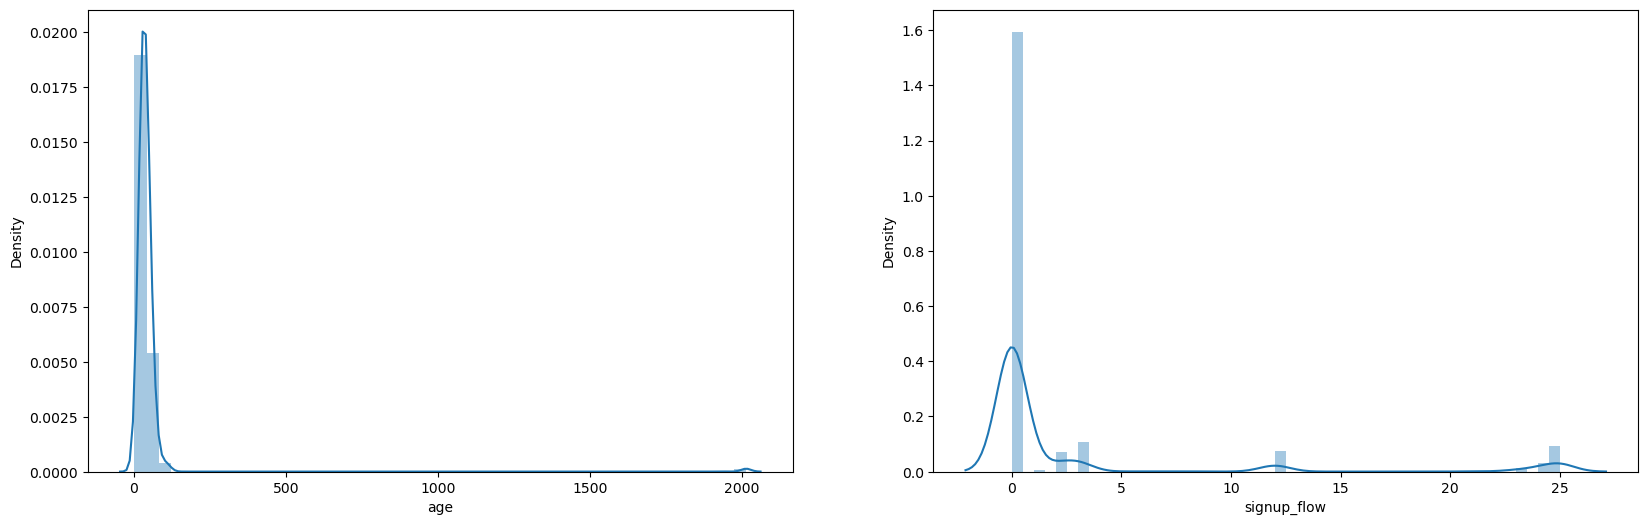

In [27]:
plt.figure(figsize = (20,6))

plt.subplot(121)
sns.distplot(df1["age"])

plt.subplot(122)
sns.distplot(df1["signup_flow"])

plt.subplots_adjust(wspace = 0.2)

In [28]:
df1["age"].value_counts().sort_values()

1926       1
2008       1
1938       1
16         1
1931       1
        ... 
28      3392
29      3423
32      3449
31      3531
30      3641
Name: age, Length: 117, dtype: int64

We may have lower ages ( <= 2 years old, for instance) in our dataset because they are children accompanied by parents. Yet, we may not have ages higher than 122, since this age is for the oldest person who ever lived on Earth. Thus, these values will be treated as outliers.

In [29]:
df1 = df1[df1["age"] <= 122]

In [30]:
df1.shape

(67797, 16)

### 1.7.2. Categorical attributes

In [31]:
cat_attributes.apply(lambda x: x.unique().shape[0] )

id                         68171
gender                         4
signup_method                  3
language                      23
affiliate_channel              8
affiliate_provider            16
first_affiliate_tracked        7
signup_app                     4
first_device_type              9
first_browser                 36
country_destination           11
dtype: int64

In [32]:
cat_attributes.drop(columns="id").apply(lambda x: x.unique() )

gender                                      [FEMALE, -unknown-, MALE, OTHER]
signup_method                                      [basic, facebook, google]
language                   [en, es, fr, zh, ko, de, it, ja, pt, ru, nl, s...
affiliate_channel          [direct, other, seo, sem-non-brand, content, s...
affiliate_provider         [direct, craigslist, google, other, facebook, ...
first_affiliate_tracked    [untracked, omg, linked, tracked-other, produc...
signup_app                                        [Web, Moweb, iOS, Android]
first_device_type          [Windows Desktop, Mac Desktop, iPhone, Desktop...
first_browser              [IE, Firefox, Chrome, Safari, -unknown-, Mobil...
country_destination          [US, other, CA, FR, IT, ES, GB, NL, DE, AU, PT]
dtype: object

# 2. Feature Engineering

In [33]:
df2 = df1.copy()

## 2.1. Hypotheses Mind Map

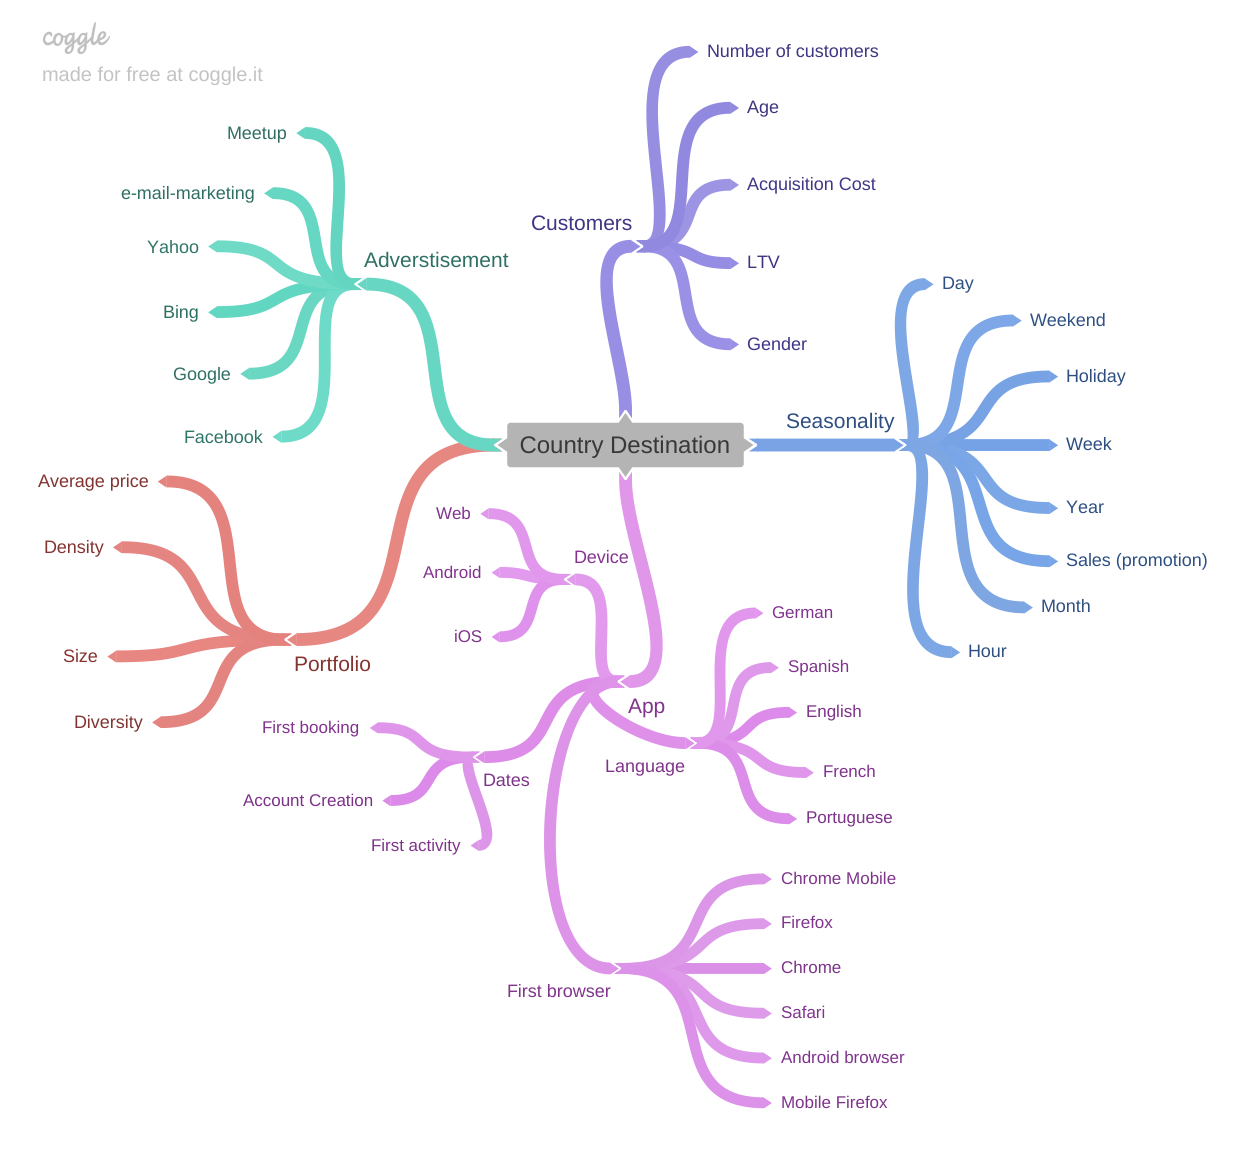

In [34]:
Image("images/HypothesesMindMap.png")

## 2.2. Hypotheses Generation

Based on the mind map above, we generated the hypotheses in this section.

### 2.2.1. App Hypotheses

### 2.2.2. Customers Hypotheses

### 2.2.3. Seasonality Hypotheses

# 3. Feature Filtering and Selection

In [35]:
df3 = df2.copy()

# 4. Exploratory Data Analysis (EDA)

In [36]:
df4 = df3.copy()

In [37]:
df4.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,2010-08-02,FEMALE,56,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,2012-09-08,FEMALE,42,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,2009-12-08 06:11:05,2010-02-18,-unknown-,41,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US
6,lsw9q7uk0j,2010-01-02,2010-01-02 01:25:58,2010-01-05,FEMALE,46,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari,US
7,0d01nltbrs,2010-01-03,2010-01-03 19:19:05,2010-01-13,FEMALE,47,basic,0,en,direct,direct,omg,Web,Mac Desktop,Safari,US


# 5. Data Preparation

In [38]:
df5 = df4.copy()

In [39]:
 # dummy variable
df5_dummy = pd.get_dummies(df5.drop(['id', 'country_destination'], axis=1))

# join id and country destination
df5 = pd.concat([df5[['id', 'country_destination']], df5_dummy], axis=1) 

In [40]:
df5.sample()

,id,country_destination,date_account_created,timestamp_first_active,date_first_booking,age,signup_flow,gender_-unknown-,gender_FEMALE,gender_MALE,...,first_browser_Safari,first_browser_SeaMonkey,first_browser_Silk,first_browser_SiteKiosk,first_browser_SlimBrowser,first_browser_Sogou Explorer,first_browser_Stainless,first_browser_TenFourFox,first_browser_TheWorld Browser,first_browser_Yandex.Browser
44968,m8p88123yv,US,2012-10-16,2012-10-16 03:44:10,2012-10-27,37,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


# 6. Feature Selection

In [41]:
cols_drop = ['date_account_created', 'timestamp_first_active', 'date_first_booking'] # original dates
df6 = df5.drop(cols_drop, axis=1)

# 7. Machine Learning Modeling

In [42]:
df7 = df6.copy()

## 7.1. Performance Metrics 

Since we have a multi-class problem and very imbalanced, in this project, we must aim for metrics which considers these characteristics.

#### Accuracy

Number of correct predictions over total number of predictions. 

- Number of correct predictions: sum of principal diagonal of the confusion matrix.
- Number of predictions: sum of all numbers of the confusion matrix.

Accuracy is biased towards a class with more available examples - and hence: more correct predictions. As we have a very imbalanced dataset, thus this is not the most proper metric to evaluate model performance. 

#### Precision

Number of correct predictions for each class over number of predictions for each class.

- Number of correct predictions for each class: intersection of class of the confusion matrix.
- Number of predictions for each class: sum of vertical numbers of a class.

We use this metric when there are classes more important than others. Although this metric is good for imbalanced/unbalanced problems, the precision is not the most important for us. We are not working with medical development, for instance.

#### Recall (Sensitivity)

Number of correct predictions for each class over number of total values for each class.

- Number of correct predictions for each class: intersection of class of the confunsion matrix.
- Number of total values for each class: sum of horizontal numbers of a class. 

We discard this metric because it is not good for imbalanced/unbalanced problems. 

#### F1-Score

Harmonious average between Precision and Recall metrics. This metric is applied as a combination of two classes (binary-class). Thus, it works very well when we are combining two classes. But our problem is multi-class, therefore this metric is not the most proper.

This metric summarize Precision and Recall. Thus, we discard this one for the same reasons discussed above. 

#### Kappa Score

It is used to measure the number of agreements between evaluators. The closer to 1, the higher the agreement between evaluators. For this project, we used this metric and our goal is a value higher than 75%. 

#### Balanced Accuracy

We need a one and only metric to evaluate the model performance. For this project, we used the balanced accuracy, since we have a very imbalanced dataset and this metric considers the accuracy of each class.

A little value means imbalanced dataset. As we balance our data, the value of this metrics increases.

## 7.2. Training and test datasets

As the data is too imbalanced (with "im": naturally without balance), we should not use accuracy as the main metric to evaluate model performance. 

In [54]:
X = df7.drop('country_destination', axis=1)
y = df7['country_destination'].copy()

In [55]:
# Split dataset into training and test
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=32)

In [56]:
x_train = X_train.drop('id', axis=1)
x_test = X_test.drop('id', axis=1)

## 7.3. Baseline Model

For a time series problem, the baseline model is an average one. For a classification problem, the baseline is a model which randomly estimates the classes we are looking at (country_destination).

In [71]:
# population is the response variable - it is in the alphabetic order for the classes
country_destination_list = df7['country_destination'].drop_duplicates().sort_values().tolist()

# number of samples generated randomly is the number of predictions we want = y_test.shape[0]
k_num = y_test.shape[0]

# number of classes - it is in the alphabetic order fot the classes
country_destination_weights = df7['country_destination'].value_counts( normalize=True ).sort_index().tolist()

# predictions
yhat_random = random.choices( population=country_destination_list,  
                              weights=country_destination_weights,
                              k=k_num )
len( yhat_random )

13560

## 7.4. Baseline Performance

Accuracy: 0.5238938053097345
Balanced Accuracy: 0.08913849388636269
Kappa Score: -0.0004290000367976887
              precision    recall  f1-score   support

          AU       0.00      0.00      0.00        80
          CA       0.01      0.01      0.01       224
          DE       0.02      0.02      0.02       170
          ES       0.02      0.02      0.02       329
          FR       0.06      0.06      0.06       746
          GB       0.02      0.02      0.02       341
          IT       0.03      0.03      0.03       395
          NL       0.00      0.00      0.00       112
          PT       0.00      0.00      0.00        32
          US       0.71      0.71      0.71      9640
       other       0.11      0.11      0.11      1491

    accuracy                           0.52     13560
   macro avg       0.09      0.09      0.09     13560
weighted avg       0.52      0.52      0.52     13560



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

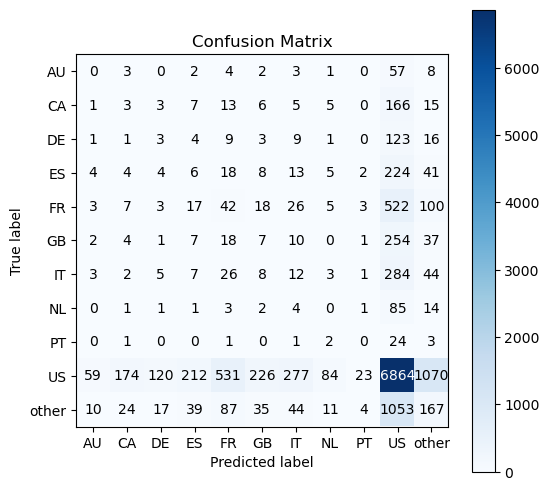

In [73]:
# Accuracy
acc_random = m.accuracy_score(y_test, yhat_random)
print('Accuracy: {}'.format(acc_random))

# Balanced Accuray
balanced_acc_random = m.balanced_accuracy_score(y_test, yhat_random)
print('Balanced Accuracy: {}'.format(balanced_acc_random))

# Kappa Metrics
kappa_random = m.cohen_kappa_score(y_test, yhat_random)
print('Kappa Score: {}'.format(kappa_random))

# Classification report
print(m.classification_report(y_test, yhat_random))

# Confusion Matrix
mt.plot_confusion_matrix(y_test, yhat_random, normalize=False, figsize=(6,6))

- Accuracy: 52%.
- Balanced Accuracy: 9%. This metric is more realistic than accuracy since we have an imbalanced dataset.
- Kappa Score is too little. 

## 7.X. Neural Network - MLP

We need to encode the response variable to work with neural network:

In [57]:
y_train

205102       US
172211       US
170678       US
172344       FR
102694       US
          ...  
166983       US
72583     other
59535        ES
188487       US
30438        US
Name: country_destination, Length: 54237, dtype: object

In [58]:
# instantiate encoder
ohe = pp.OneHotEncoder()

# y train for neural network
y_train_nn = ohe.fit_transform(y_train.values.reshape(-1, 1)).toarray()

In [59]:
y_train_nn

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

Artifical Neural Network (ANN) - Multi-Layer Perceptron (MLP)

- We used softmax in the final layer because this one is good when the response variable is categorical. 
- Accuracy is the main metric to evaluate a classification model.

In [60]:
 # model definition
model = ml.Sequential()

# first layer
model.add(l.Dense(128, input_dim=x_train.shape[1], activation='relu'))

# last layer
model.add(l.Dense(11, activation='softmax'))

# model compile
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# train model
model.fit(x_train, y_train_nn, epochs=100)

Epoch 1/100
1695/1695 [==============================] - 2s 934us/step - loss: 1.1980 - accuracy: 0.7046
Epoch 2/100
1695/1695 [==============================] - 2s 964us/step - loss: 1.1597 - accuracy: 0.7081
Epoch 3/100
1695/1695 [==============================] - 2s 946us/step - loss: 1.1524 - accuracy: 0.7084
Epoch 4/100
1695/1695 [==============================] - 2s 954us/step - loss: 1.1495 - accuracy: 0.7083
Epoch 5/100
1695/1695 [==============================] - 2s 925us/step - loss: 1.1446 - accuracy: 0.7084
Epoch 6/100
1695/1695 [==============================] - 2s 888us/step - loss: 1.1416 - accuracy: 0.7084
Epoch 7/100
1695/1695 [==============================] - 2s 919us/step - loss: 1.1402 - accuracy: 0.7084
Epoch 8/100
1695/1695 [==============================] - 2s 891us/step - loss: 1.1394 - accuracy: 0.7085
Epoch 9/100
1695/1695 [==============================] - 2s 947us/step - loss: 1.1378 - accuracy: 0.7085
Epoch 10/100
1695/1695 [==============================]

1695/1695 [==============================] - 2s 921us/step - loss: 1.0960 - accuracy: 0.7117
Epoch 79/100
1695/1695 [==============================] - 2s 1ms/step - loss: 1.0962 - accuracy: 0.7115
Epoch 80/100
1695/1695 [==============================] - 2s 1ms/step - loss: 1.0962 - accuracy: 0.7115
Epoch 81/100
1695/1695 [==============================] - 2s 973us/step - loss: 1.0955 - accuracy: 0.7115
Epoch 82/100
1695/1695 [==============================] - 2s 1ms/step - loss: 1.0959 - accuracy: 0.7118
Epoch 83/100
1695/1695 [==============================] - 2s 1000us/step - loss: 1.0954 - accuracy: 0.7116
Epoch 84/100
1695/1695 [==============================] - 2s 914us/step - loss: 1.0948 - accuracy: 0.7116
Epoch 85/100
1695/1695 [==============================] - 1s 883us/step - loss: 1.0954 - accuracy: 0.7119
Epoch 86/100
1695/1695 [==============================] - 2s 932us/step - loss: 1.0942 - accuracy: 0.7120
Epoch 87/100
1695/1695 [==============================] - 2s 920

## 7.X. ANN Performance

In [61]:
# prediction
pred_nn = model.predict(x_test)

# invert prediction - going back to the categorical attributes 
# real prediction
yhat_nn = ohe.inverse_transform(pred_nn)

# prediction prepare
y_test_nn = y_test.to_numpy()
yhat_nn = yhat_nn.reshape(1, -1)[0]

424/424 [==============================] - 0s 706us/step


Accuracy: 0.7073008849557522
Balanced Accuracy: 0.09117849603966205
Kappa Score: -0.0012571237493061993


/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          AU       0.00      0.00      0.00        80
          CA       0.00      0.00      0.00       224
          DE       0.50      0.01      0.01       170
          ES       0.00      0.00      0.00       329
          FR       0.00      0.00      0.00       746
          GB       0.00      0.00      0.00       341
          IT       0.00      0.00      0.00       395
          NL       0.00      0.00      0.00       112
          PT       0.00      0.00      0.00        32
          US       0.71      0.99      0.83      9640
       other       0.11      0.00      0.01      1491

    accuracy                           0.71     13560
   macro avg       0.12      0.09      0.08     13560
weighted avg       0.52      0.71      0.59     13560



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

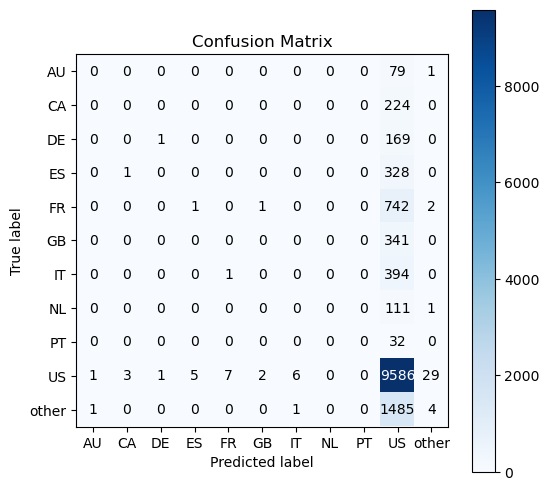

In [66]:
# Accuracy
acc_nn = m.accuracy_score(y_test_nn, yhat_nn)
print('Accuracy: {}'.format(acc_nn))

# Balanced Accuray
balanced_acc_nn = m.balanced_accuracy_score( y_test_nn, yhat_nn)
print('Balanced Accuracy: {}'.format(balanced_acc_nn))

# Kappa Metrics
kappa_nn = m.cohen_kappa_score(y_test_nn, yhat_nn)
print('Kappa Score: {}'.format(kappa_nn))

# Classification report
print(m.classification_report(y_test_nn, yhat_nn))

# Confusion Matrix
mt.plot_confusion_matrix(y_test_nn, yhat_nn, normalize=False, figsize=(6,6))

- Accuracy of 71% is a good one, but... 
- The model chose US even when the true class was other countries.
- The neural network is biased towards the class with more available examples: US.


- The majority of predictions for US were correct. For true US, the wrong predictions were: CA (1), DE (5), ES (1), FR (7), GB (4) and IT (2). 
- AU: accuracy = 0%. CA: accuracy = 0%. All predictions for AU and CA were wrong.

Accuracy basically is: how much right predictions I have chose correctly over the amount of predictions I did. 

- Balanced Accuracy of 9% is much more realistic. We want to increase it to values around 85%.
- Kappa Score is not good enough. We want values higher than 70%.